In [1]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
import Graph_Sampling

In [3]:
# ground truth matrix 
n =20 
n_users = 20 
np.random.seed(0)
gt = scipy.sparse.random(n,20,density=0.25)
b = np.array(gt.A>0,dtype='int')

N = 1000
observations = np.zeros((N,n,n_users))
for i in range(N):
    # add noise
    noise = scipy.sparse.random(n,20,density=0.05)
    c = np.array(gt.A+noise>0,dtype='int')

    # only partially observe matrix
    observed = np.zeros((n,20),dtype='int')
    positive_indices = np.argwhere(c>0)

    fraction = 0.8
    observed_samples = np.random.randint(len(positive_indices),size=int(np.ceil(fraction*len(positive_indices))))
    #observed_samples_y = np.random.randint(len(positive_indices),size=int(np.ceil(fraction*len(positive_indices))))
    #print(observed_samples)
    observed_indices = positive_indices[observed_samples]
    #print(observed_indices)
    observed[observed_indices[:,0],observed_indices[:,1]] = 1 
    observations[i,:,:] = observed
print(b)
print(observations[0])

[[0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0]
 [1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0]
 [1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0]
 [1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0]
 [1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0]
 [1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1]
 [0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1]]
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0.

19.0


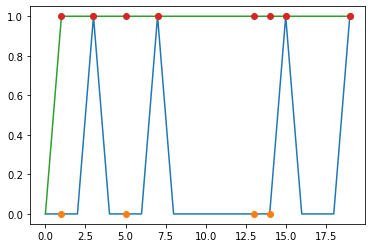

In [9]:
# Combinatorial UCB 
import math 

class combinatorial_UCB(object):
    def __init__(self,n_rounds,n_clients,algorithm='UCB1_tuned'):
        self.n_clients = n_clients 
        self.n_rounds = n_rounds 
        
        # define variables for storage 
        # which clients we select 
        self.times_selected = np.zeros((n_clients,n_clients)) # to record how often each client got selected 
        self.reward_per_client = np.zeros((n_clients,n_clients)) # to record what reward we collected per client 
        self.reward2_per_client = np.zeros((n_clients,n_clients)) # to record the squared reward per client (needed for UCB1-tuned)
        # how many clients we select 
        self.n_clients_selected_arr = []
        self.reward3_per_client = np.zeros((n_clients,n_clients-1))
        self.times_selected2 = np.zeros((n_clients,n_clients-1))
        
        self.algorithm = algorithm
        

    def UCB(self,this_client): 
        #for this_client in range(self.n_clients):
        other_clients = [x for x in range(self.n_clients) if x is not this_client]

        upper_bound = np.zeros(self.n_clients)
        for i,other_client in enumerate(other_clients):
            if self.times_selected[this_client,other_client]==0: # make first iteration value high
                upper_bound[other_client] = 1e500 
            else: 
                # We first calculate the average reward gained for this client 
                average_reward = self.reward_per_client[this_client,other_client] / self.times_selected[this_client,other_client]

                # Then we compute the confidence interval [avg_reward - delta, avg_reward + delta]
                if self.algorithm == 'UCB1':
                    delta = math.sqrt( 2 * math.log(n) / self.times_selected[this_client,other_client])

                if self.algorithm == 'UCB1_tuned':
                    variance_bound = self.reward2_per_client[this_client,other_client] / self.times_selected[this_client,other_client] - average_reward**2
                    variance_bound += math.sqrt(2 * math.log(n)/self.times_selected[this_client,other_client])

                    factor = np.min([variance_bound, 1/4])
                    delta = math.sqrt( factor * math.log(n) / self.times_selected[this_client,other_client] )

                # upper bound 
                upper_bound[other_client] = average_reward + delta 

        if self.algorithm == 'random': 
            upper_bound = np.random.rand(self.n_clients)

        # select the client with the highest upper bound 
        sorted_upper_bound = np.flip(np.argsort(upper_bound))

        # Run UCB again to determine the number of clients 
        upper_bound2 = np.zeros(self.n_clients-1)
        for ii in range(1,self.n_clients-1):
            if self.times_selected2[this_client,ii]==0: # make first iteration value high
                upper_bound2[ii] = 1e500
                n_clients_selected = n_clients -2
            else: 
                # predict the reward when selecting these clients 
                average_reward_n_clients = self.reward3_per_client[this_client,ii] / self.times_selected2[this_client,ii]
                delta = math.sqrt(2*math.log(n)) / np.sum(self.times_selected2[this_client,ii])

                upper_bound2[ii] = average_reward_n_clients + delta 

                n_clients_selected = np.argmax(upper_bound2) 

        #n_clients_selected_arr.append(n_clients_selected)
        selected_clients = sorted_upper_bound[:int(n_clients_selected+1)]

        self.times_selected[this_client,selected_clients] += 1 
        return selected_clients 
    
    def collect_reward(self,this_client,selected_clients,observations): 
        # collect the reward 
        reward = observations[this_client,selected_clients]#df.iloc[n,selected_client]
        self.reward_per_client[this_client,selected_clients] += reward 
        self.reward2_per_client[this_client,selected_clients] += reward**2

        # reward for numbers of clients selected 
        n_clients_selected = len(selected_clients)-1
        self.times_selected2[this_client,n_clients_selected] += 1 
        reward2 = np.abs(n_clients_selected - np.sum(observations[this_client,:]))
        self.reward3_per_client[this_client,n_clients_selected] += 1 - reward2 / self.n_clients

            
    def to_client(self,this_client):
        #for n in range(self.n_rounds):
        for this_client in [0]: 
            self.selected_clients = self.UCB(this_client)
            #print(selected_clients)
            return self.selected_clients
        
    def to_server(self,this_client,observation): 
        self.collect_reward(this_client,self.selected_clients,observation)
                
n_rounds = 0
n_clients = n_users
comb_UCB = combinatorial_UCB(n_rounds,n_clients)
for i in range(1):
    observation_1 = observations[i,:,:]
    selected_clients = comb_UCB.to_client([0])
    comb_UCB.to_server([0],observation_1)

#print(times_selected)
client =0
x = np.array([x for x in range(20)])#print(reward_per_round[client,:])
ind = np.ravel(np.argwhere(b[client,:]==1))
#print(ind)
#print(b[client,:])
q = x[ind] #print(np.shape(reward_per_client))
plt.plot(comb_UCB.reward_per_client[client,:]);
plt.plot(q,comb_UCB.reward_per_client[client,ind],'o');
plt.plot(comb_UCB.times_selected[client,:]);
plt.plot(q,comb_UCB.times_selected[client,ind],'o');#print(reward_per_client[client,:])#print(19*1000)
print(np.sum(comb_UCB.times_selected[client,:]))

In [5]:
# Combinatorial UCB 
import math 

n_rounds = N # the number of rounds 
n_clients = n_users # the number of clients 
clients_selected = [] # to record what clients got selected 
times_selected = np.zeros((n_clients,n_clients)) # to record how often each client got selected 
reward_per_client = np.zeros((n_clients,n_clients)) # to record what reward we collected per client 
reward2_per_client = np.zeros((n_clients,n_clients)) # to record the squared reward per client (needed for UCB1-tuned)
total_reward = 0  # the total reward we collected 
algorithm = 'UCB1_tuned'

n_clients_selected_arr = []
#n_clients_selected_total = np.zeros(n_clients)
reward3_per_client = np.zeros((n_clients,n_clients-1))
times_selected2 = np.zeros((n_clients,n_clients-1))
eps = 0.00005

for n in range(n_rounds):#[0,1]: #
    
    for this_client in range(n_clients):
        other_clients = [x for x in range(n_clients) if x is not this_client]
        
        upper_bound = np.zeros(n_clients)
        for i,other_client in enumerate(other_clients):
            if times_selected[this_client,other_client]==0: # make first iteration value high
                upper_bound[other_client] = 1e500 
            else: 
                # We first calculate the average reward gained for this client 
                average_reward = reward_per_client[this_client,other_client] / times_selected[this_client,other_client]

                # Then we compute the confidence interval [avg_reward - delta, avg_reward + delta]
                if algorithm == 'UCB1':
                    delta = math.sqrt( 2 * math.log(n) / times_selected[this_client,other_client])

                if algorithm == 'UCB1_tuned':
                    variance_bound = reward2_per_client[this_client,other_client] / times_selected[this_client,other_client] - average_reward**2
                    variance_bound += math.sqrt(2 * math.log(n)/times_selected[this_client,other_client])

                    factor = np.min([variance_bound, 1/4])
                    delta = math.sqrt( factor * math.log(n) / times_selected[this_client,other_client] )

                # upper bound 
                upper_bound[other_client] = average_reward + delta 
                
        if algorithm == 'random': 
            upper_bound = np.random.rand(n_clients)
            
        # select the client with the highest upper bound 
        sorted_upper_bound = np.flip(np.argsort(upper_bound))
       
        # Run UCB again to determine the number of clients 
        upper_bound2 = np.zeros(n_clients-1)
        for ii in range(1,n_clients-1):
            if times_selected2[this_client,ii]==0: # make first iteration value high
                upper_bound2[ii] = 1e500
                n_clients_selected = n_clients -2
            else: 
                # predict the reward when selecting these clients 
                average_reward_n_clients = reward3_per_client[this_client,ii] / times_selected2[this_client,ii]
                delta = math.sqrt(2*math.log(n)) / np.sum(times_selected2[this_client,ii])

                upper_bound2[ii] = average_reward_n_clients + delta 

                n_clients_selected = np.argmax(upper_bound2) 

        n_clients_selected_arr.append(n_clients_selected)
        selected_clients = sorted_upper_bound[:int(n_clients_selected+1)]

        times_selected[this_client,selected_clients] += 1 

        # collect the reward 
        reward = observations[n,this_client,selected_clients]#df.iloc[n,selected_client]
        reward_per_client[this_client,selected_clients] += reward 
        reward2_per_client[this_client,selected_clients] += reward**2
        
        # reward for numbers of clients selected 
        times_selected2[this_client,n_clients_selected] += 1 
        reward2 = np.abs(n_clients_selected - np.sum(observations[n,this_client,:]))
        reward3_per_client[this_client,n_clients_selected] += 1 - reward2 / n_clients
        


6583.0


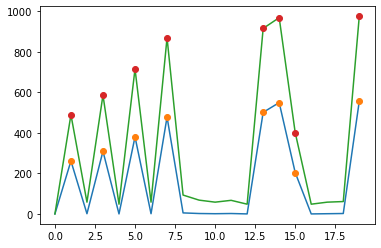

In [6]:
#print(times_selected)
client =0
x = np.array([x for x in range(20)])#print(reward_per_round[client,:])
ind = np.ravel(np.argwhere(b[client,:]==1))
#print(ind)
#print(b[client,:])
q = x[ind] #print(np.shape(reward_per_client))
plt.plot(reward_per_client[client,:]);
plt.plot(q,reward_per_client[client,ind],'o');
plt.plot(times_selected[client,:]);
plt.plot(q,times_selected[client,ind],'o');#print(reward_per_client[client,:])#print(19*1000)
print(np.sum(times_selected[client,:]))

In [ ]:
print(times_selected[client,:])
print(times_selected2[client,:])
print(np.argmax(times_selected2[client,:]+1))
print(np.sum(times_selected[client,:]))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[160 166 170 159 149 135 123 111 104 101  94  85  82  80  80  74  65  62]
[ 9  8  2 12  7 11  0 13 14 15 16 17  3  1 10 18  6]


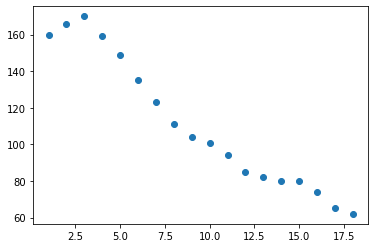

In [624]:
#plt.plot(n_clients_selected_arr)
unique,counts = np.unique(n_clients_selected_arr,return_counts=True)
print(unique)
print(counts)
print(selected_clients)
plt.plot(unique,counts,'o')

In [612]:
print(reward2)
print(np.sum(observations[n,this_client,selected_clients]))
print(np.sum(observations[n,this_client,:]))
print(upper_bound2)
print(len(selected_clients))
print(selected_clients)

5.0
5.0
5.0
[0.         1.29692347 1.31359014 1.33307726 1.35450583 1.35450583
 1.3414426  1.3259344  1.33859014 1.3302568  1.37630816 1.26630816
 1.25630816 1.3203852  1.2703852  1.2578852  1.1703852  1.1578852
 1.1203852 ]
11
[15 19 13  3 14  5  1  7 16 12 11]


In [345]:
print(sorted_upper_bound)
print(upper_bound)
print(upper_bound2)

[17 13  0  7 18 16 11 12 19 14  5  4 10  6  3  8  9 15  2  1]
[0.23578423 0.         0.04421968 0.04480732 0.04637673 0.04701914
 0.04562282 0.22748399 0.04426879 0.04426879 0.0459657  0.0492051
 0.04832088 0.2369772  0.04729279 0.04425104 0.049354   0.24525333
 0.22261117 0.04778606]
[0.         0.32442228 0.48221602 0.65974087 0.83415976 1.00786203
 1.01617773 1.02432832 1.03266836 1.04121595 1.04806339 1.055051
 1.06204664 1.07090754 1.0789426  1.08383342 1.08750904 1.09125216
 1.09225151]


In [331]:
print(reward_per_round[0])
print(times_selected2[0])
print(reward_per_round[0]/times_selected2[0])

client = 0
x = np.array([x for x in range(20)])
ind = np.ravel(np.argwhere(b[client,:]==1))
print(ind)

[  0.   0.   1.   1.   2.   1.   2.   1.  40.  32.  12. 317.  38.  10.
 264.  20.   4. 436. 335.]
[  0.   3.   3.   3.   4.   3.   4.   3.  28.  23.  10. 199.  27.   9.
 169.  15.   5. 278. 214.]
[       nan 0.         0.33333333 0.33333333 0.5        0.33333333
 0.5        0.33333333 1.42857143 1.39130435 1.2        1.59296482
 1.40740741 1.11111111 1.56213018 1.33333333 0.8        1.56834532
 1.56542056]
[ 1  3  5  7 13 14 15 19]


/tmp/ipykernel_953459/858112920.py:3: RuntimeWarning: invalid value encountered in divide
  print(reward_per_round[0]/times_selected2[0])


In [285]:
# UCB with one client per round 
import math 

n_rounds = N # the number of rounds 
n_clients = n_users # the number of clients 
clients_selected = [] # to record what clients got selected 
times_selected = np.zeros((n_clients,n_clients)) # to record how often each client got selected 
reward_per_client = np.zeros((n_clients,n_clients)) # to record what reward we collected per client 
reward2_per_client = np.zeros((n_clients,n_clients)) # to record the squared reward per client (needed for UCB1-tuned)
total_reward = 0  # the total reward we collected 
algorithm = 'UCB1_tuned'

for n in range(n_rounds):
    
    for this_client in [0]: #range(n_clients):
        other_clients = [x for x in range(n_clients) if x is not this_client]
        
        upper_bound = np.zeros(n_clients)
        for i,other_client in enumerate(other_clients):
            if times_selected[this_client,other_client]==0: # make first iteration value high
                upper_bound[other_client] = 1e500 
            else: 
                # We first calculate the average reward gained for this client 
                average_reward = reward_per_client[this_client,other_client] / times_selected[this_client,other_client]

                # Then we compute the confidence interval [avg_reward - delta, avg_reward + delta]
                if algorithm == 'UCB1':
                    delta = math.sqrt( 2 * math.log(n) / times_selected[this_client,other_client])

                if algorithm == 'UCB1_tuned':
                    variance_bound = reward2_per_client[this_client,other_client] / times_selected[this_client,other_client] - average_reward**2
                    variance_bound += math.sqrt(2 * math.log(n)/times_selected[this_client,other_client])

                    factor = np.min([variance_bound, 1/4])
                    delta = math.sqrt( factor * math.log(n) / times_selected[this_client,other_client] )

                # upper bound 
                upper_bound[other_client] = average_reward + delta 
        if algorithm == 'random': 
            upper_bound = np.random.rand(n_clients)
        #print(upper_bound)
        # select the client with the highest upper bound 
        selected_client = np.argmax(upper_bound)
        #clients_selected.append(selected_client)
        times_selected[this_client,selected_client] += 1 

        # collect the reward 
        reward = observations[n,this_client,selected_client]#df.iloc[n,selected_client]
        total_reward += reward 
        reward_per_client[this_client,selected_client] += reward 
        reward2_per_client[this_client,selected_client] += reward**2


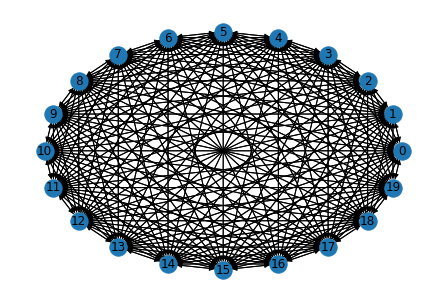

In [280]:
# create graph from 
GS = nx.DiGraph()
for i in range(n_clients):
    for j in range(n_clients):
        if times_selected[i][j] >= 1 :
            GS.add_edge(i,j,weight=times_selected[i][j])
nx.draw(GS,pos=nx.circular_layout(GS),with_labels=True)
partitions = nx.algorithms.community.louvain_communities(GS)

In [281]:
print(partitions)

[{16, 19, 9, 15}, {18, 3, 11}, {2, 5, 6, 7, 12}, {0, 1, 4, 13}, {8, 17, 10, 14}]


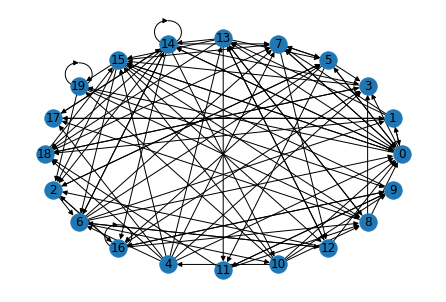

In [274]:
# plot "true" graph 
#start = np.ones((10,10))
GS = nx.DiGraph()
for i in range(n_clients):
    for j in range(n_clients):
        if b[i][j] == 1 :
            GS.add_edge(i,j)
nx.draw(GS,pos=nx.circular_layout(GS),with_labels=True)

### 1D case 

In [227]:
# ground truth matrix 
n = 1 
n_users = 20 
np.random.seed(0)
gt = scipy.sparse.random(n,20,density=0.25)
b = np.array(gt.A>0,dtype='int')

N = 100
observations = np.zeros((N,n_users))
for i in range(N):
    # add noise
    noise = scipy.sparse.random(n,20,density=0.05)
    c = np.array(gt.A+noise>0,dtype='int')

    # only partially observe matrix
    observed = np.zeros((n,20),dtype='int')
    positive_indices = np.argwhere(c>0)

    fraction = 0.2 
    observed_samples = np.random.randint(len(positive_indices),size=int(np.ceil(fraction*len(positive_indices))))
    observed_indices = positive_indices[observed_samples]
    observed[observed_indices[:,0],observed_indices[:,1]] = 1 
    observations[i,:] = observed[0]
print(b)

[[0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1]]


In [235]:
import math 

n_rounds = N # the number of rounds 
n_clients = n_users # the number of clients 
clients_selected = [] # to record what clients got selected 
times_selected = np.zeros(n_clients) # to record how often each client got selected 
reward_per_client = np.zeros(n_clients) # to record what reward we collected per client 
reward2_per_client = np.zeros(n_clients) # to record the squared reward per client (needed for UCB1-tuned)
total_reward = 0  # the total reward we collected 
algorithm = 'UCB1_tuned'

for n in range(n_rounds):
    
    upper_bound = np.zeros(n_clients)
    
    for client in range(n_clients):
        if times_selected[client]==0: # make first iteration value high
            upper_bound[client] = 1e500 
        else: 
            # We first calculate the average reward gained for this client 
            average_reward = reward_per_client[client] / times_selected[client]

            # Then we compute the confidence interval [avg_reward - delta, avg_reward + delta]
            if algorithm == 'UCB1':
                delta = math.sqrt( 2 * math.log(n) / times_selected[client])
            
            if algorithm == 'UCB1_tuned':
                variance_bound = reward2_per_client[client] / times_selected[client] - average_reward**2
                variance_bound += math.sqrt(2 * math.log(n)/times_selected[client])
                
                factor = np.min([variance_bound, 1/4])
                delta = math.sqrt( factor * math.log(n) / times_selected[client] )

            # upper bound 
            upper_bound[client] = average_reward + delta 
    if algorithm == 'random': 
        upper_bound = np.random.rand(n_clients)
    print(upper_bound)
    # select the client with the highest upper bound 
    selected_client = np.argmax(upper_bound)
    clients_selected.append(selected_client)
    times_selected[selected_client] += 1 
    
    # collect the reward 
    reward = observations[n,selected_client]#df.iloc[n,selected_client]
    total_reward += reward 
    reward_per_client[selected_client] += reward 
    reward2_per_client[selected_client] += reward**2


[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]
[ 0. inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]
[0.41627731 0.41627731        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf]
[0.52407354 0.52407354 0.52407354        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf]
[0.58870501 0.58870501 0.58870501 0.58870501        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf]
[0.63431812 0.63431812 0.63431812 0.63431812 0.63431812        inf
        inf        inf        inf        inf        inf        inf
        inf        inf   

[ 4. 23.  4.  3.  3.  3.  3.  3. 15.  3.  6.  3.  3.  3.  3.  3.  3.  3.
  3.  6.]
[ 1  8 10 18 19]


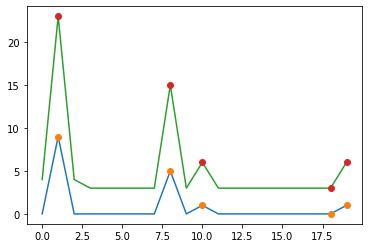

In [229]:
print(times_selected)
x = np.array([x for x in range(20)])
ind = np.ravel(np.argwhere(b[0]==1))
print(ind)

q = x[ind]

plt.plot(reward_per_client)
plt.plot(q,reward_per_client[ind],'o')
plt.plot(times_selected)
plt.plot(q,times_selected[ind],'o')

[5. 5. 4. 3. 2. 8. 6. 8. 8. 3. 6. 6. 3. 3. 7. 5. 5. 5. 5. 3.]
[ 1  8 10 18 19]


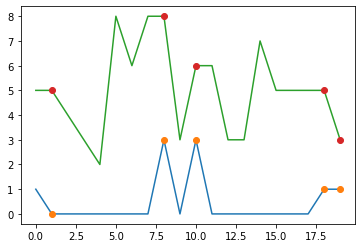

In [234]:
print(times_selected)
x = np.array([x for x in range(20)])
ind = np.ravel(np.argwhere(b[0]==1))
print(ind)

q = x[ind]

plt.plot(reward_per_client)
plt.plot(q,reward_per_client[ind],'o')
plt.plot(times_selected)
plt.plot(q,times_selected[ind],'o')

In [151]:
import torch.nn as nn
import copy
import torch
class Net(nn.Module):
    def __init__(self,dataset,out=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        if dataset == 'FEMNIST':
            self.fc2 = nn.Linear(100, 62)
        if dataset == 'MNIST_niid':
            self.fc2 = nn.Linear(100,out)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=-1)

model = Net('MNIST_niid')
init = copy.deepcopy(model)
print(model.conv2.weight.shape)
PATH = '/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits/local/model/best_model1.pt'
model.load_state_dict(torch.load(PATH))


torch.Size([20, 10, 5, 5])


<All keys matched successfully>

In [152]:
model_1 = copy.deepcopy(model)
PATH = '/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits/local/model/best_model2.pt'
model.load_state_dict(torch.load(PATH))
model_2 = copy.deepcopy(model)
PATH = '/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits/local/model/best_model3.pt'
model.load_state_dict(torch.load(PATH))
model_3 = copy.deepcopy(model)

In [157]:
for (name,param),(name2,param2),(name3,param3),(name4,param4) in zip(init.named_parameters(),model_1.named_parameters(),model_2.named_parameters(),model_3.named_parameters()):
    param.data =  (1/3) * param2.data + (1/3)* param3.data + (1/3)* param4.data 

In [164]:
difference1 = 0 
difference2 = 0 
difference3 = 0 

for (name,param),(name2,param2),(name3,param3),(name4,param4) in zip(init.named_parameters(),model_1.named_parameters(),model_2.named_parameters(),model_3.named_parameters()):
    diff = param2.data - param.data
    difference1 += torch.abs(torch.sum(diff))
    #print(torch.topk(diff.flatten(),20).indices)
    
    diff2 = param3.data - param.data 
    difference2 += torch.abs(torch.sum(diff2))
    #print(torch.topk(diff2.flatten(),20).indices)
    
    diff3 = param4.data - param.data 
    difference3 += torch.abs(torch.sum(diff3))
    #print(torch.topk(diff3.flatten(),20).indices)

print(difference1)
print(difference2)
print(difference3)

tensor(49.0830)
tensor(27.6497)
tensor(74.0049)


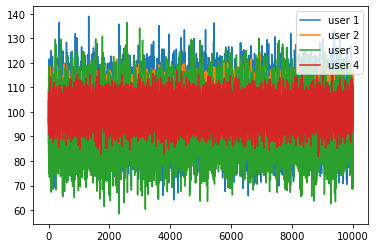

In [111]:
# code from hackdeploy 
m1 = np.random.normal(100,10,10000)
m2 = np.random.normal(105,5,10000)
m3 = np.random.normal(95,10,10000)
m4 = np.random.normal(100,5,10000)

df = pd.DataFrame({"m1":m1, "m2":m2,"m3": m3,"m4": m4})

plt.plot(m1,label='user 1')
plt.plot(m2,label='user 2')
plt.plot(m3,label='user 3')
plt.plot(m4,label='user 4')
plt.legend()

In [165]:
import math 

n_rounds = df.shape[0] # the number of rounds 
n_clients = df.shape[1] # the number of clients 
clients_selected = [] # to record what clients got selected 
times_selected = np.zeros(n_clients) # to record how often each client got selected 
reward_per_client = np.zeros(n_clients) # to record what reward we collected per client 
reward2_per_client = np.zeros(n_clients) # to record the squared reward per client (needed for UCB1-tuned)
total_reward = 0  # the total reward we collected 
algorithm = 'UCB1_tuned'

for n in range(n_rounds):
    
    upper_bound = np.zeros(n_clients)
    
    for client in range(n_clients):
        if times_selected[client]==0: # make first iteration value high
            upper_bound[client] = 1e500 
        else: 
            # We first calculate the average reward gained for this client 
            average_reward = reward_per_client[client] / times_selected[client]

            # Then we compute the confidence interval [avg_reward - delta, avg_reward + delta]
            if algorithm == 'UCB1':
                delta = math.sqrt( 2 * math.log(n) / times_selected[client])
            
            if algorithm == 'UCB1_tuned':
                variance_bound = reward2_per_client[client] / times_selected[client] - average_reward**2
                variance_bound += math.sqrt(2 * math.log(n)/times_selected[client])
                
                factor = np.min([variance_bound, 1/4])
                delta = math.sqrt( factor * math.log(n) / times_selected[client] )

            # upper bound 
            upper_bound[client] = average_reward + delta 
        
    # select the client with the highest upper bound 
    selected_client = np.argmax(upper_bound)
    clients_selected.append(selected_client)
    times_selected[selected_client] += 1 
    
    # collect the reward 
    reward = df.iloc[n,selected_client]
    total_reward += reward 
    reward_per_client[selected_client] += reward 
    reward2_per_client[selected_client] += reward**2


[2.000e+00 9.995e+03 1.000e+00 2.000e+00]


Text(0.5, 1.0, 'Number of times each Message was Selected')

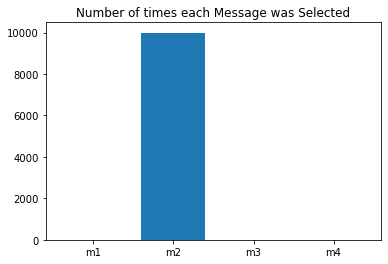

In [166]:
print(times_selected)
plt.bar(['m1','m2','m3','m4'],times_selected)
plt.title("Number of times each Message was Selected")

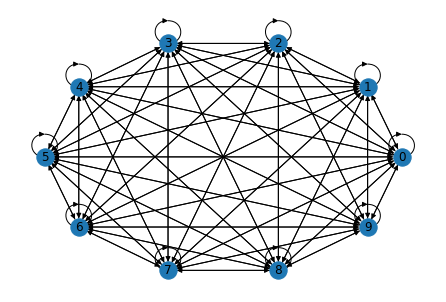

In [4]:
start = np.ones((10,10))
GS = nx.DiGraph()
for i in range(10):
    for j in range(10):
        if start[i][j] == 1 :
            GS.add_edge(i,j)
nx.draw(GS,pos=nx.circular_layout(GS),with_labels=True)

In [42]:
import pandas as pd 
dataset = pd.read_csv('Ads_Optimisation.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Ads_Optimisation.csv'

In [ ]:
# random walk with restarts 


In [5]:
# FF algorithm: Baseline 
symmetry = False 
initial_graph = np.ones((10,10)) - np.eye(10) #here, we collect the edges that have not been visited. make this triangular if we have a symmetric case
estimated_graph = np.zeros((10,10))
GT = b 


loss = []
visited_arr = []
i = 0 
while np.sum(initial_graph) > 0 : 
    # check what nodes still have outgoing links: 
    blub = np.where(np.sum(initial_graph,axis=1)>0)[0]
    # select a random node 
    random_index = np.random.randint(len(blub),size=1)
    random_node = blub[random_index]

    optional_links = np.where(initial_graph[random_node,:]>0)[1]

    if len(optional_links)>1: 
        z = np.random.randint(1,len(optional_links),size=1)
        links_indices = random.choices(list(np.arange(len(optional_links))),k=z[0])
        links_to_visit = optional_links[links_indices]
    else: 
        links_to_visit = optional_links 
    initial_graph[random_node,links_to_visit] = 0 
    estimated_graph[random_node,links_to_visit] = b[random_node,links_to_visit]

    #print(-np.sum(estimated_graph-GT)/np.sum(GT))
    #print(np.sum(initial_graph))
    loss.append(-np.sum(estimated_graph-GT)/np.sum(GT))
    visited_arr.append(len(links_to_visit))
    i += 1 
print(initial_graph)
print(i)

plt.plot(loss)


NameError: name 'b' is not defined

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
46


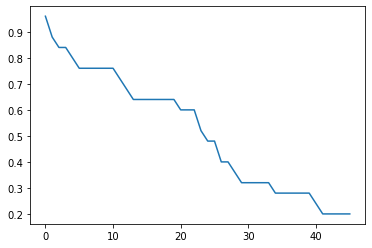

In [103]:
# FF algorithm: Baseline 
symmetry = False 
initial_graph = np.ones((10,10)) - np.eye(10) #here, we collect the edges that have not been visited. make this triangular if we have a symmetric case
estimated_graph = np.zeros((10,10))
GT = b 


loss = []
visited_arr = []
i = 0 
while np.sum(initial_graph) > 0 : 
    # check what nodes still have outgoing links: 
    blub = np.where(np.sum(initial_graph,axis=1)>0)[0]
    # select a random node 
    random_index = np.random.randint(len(blub),size=1)
    random_node = blub[random_index]

    optional_links = np.where(initial_graph[random_node,:]>0)[1]

    if len(optional_links)>1: 
        z = np.random.randint(1,len(optional_links),size=1)
        links_indices = random.choices(list(np.arange(len(optional_links))),k=z[0])
        links_to_visit = optional_links[links_indices]
    else: 
        links_to_visit = optional_links 
    initial_graph[random_node,links_to_visit] = 0 
    estimated_graph[random_node,links_to_visit] = b[random_node,links_to_visit]

    #print(-np.sum(estimated_graph-GT)/np.sum(GT))
    #print(np.sum(initial_graph))
    loss.append(-np.sum(estimated_graph-GT)/np.sum(GT))
    visited_arr.append(len(links_to_visit))
    i += 1 

print(i)
plt.plot(loss)


In [6]:
plt.plot(visited_arr)

NameError: name 'visited_arr' is not defined

In [7]:
b = b - np.eye(10)
GT = nx.DiGraph()
for i in range(10):
    for j in range(10):
        if b[i][j] == 1 :
            GT.add_edge(i,j)
nx.draw(GT,pos=nx.circular_layout(GT),with_labels=True)

NameError: name 'b' is not defined

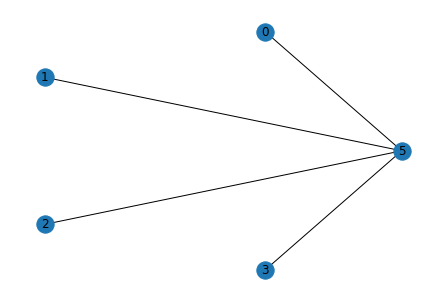

In [35]:
object = Graph_Sampling.Snowball()
size = 4 
k = 4 
sampled_subgraph = object.snowball(GS,size,k)

nx.draw(sampled_subgraph,pos=nx.circular_layout(sampled_subgraph),with_labels=True)

In [21]:
import random
def algorithm_2(A, sample_size, n, N, symmetric=False):
    def construct_X(N, k): 
        K = random.sample(list(np.arange(N)),k)
        X1 = np.zeros((n,n))
        X1[:,K] = A[:,K]
        
        if symmetric: 
            X1[K,:] = A[:,K].T
        P1 = np.full((n,n),np.sqrt(1/n))
        X1 = np.diag(P1)*X1 
        return X1,k
    k = int(np.floor(sample_size / 2))
    alpha = 0.5
    X1,K1 = construct_X(N,k)
    print(X1)
    print(K1)
    X2,K2 = construct_X(list(set(N)-set(K1)),k)
    
    A_algo2 = alpha*X1 + (1-alpha)*X2

    return A_algo2 

output = algorithm_2(b,5,10,10)
print(output)
    
    
    
    

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.31622777]
 [0.         0.         0.         0.31622777 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.31622777 0.         0.
  0.         0.         0.         0.31622777]
 [0.         0.         0.         0.

TypeError: 'int' object is not iterable